<>:43: SyntaxWarning: invalid escape sequence '\p'
<>:43: SyntaxWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_19180\3354545339.py:43: SyntaxWarning: invalid escape sequence '\p'
  self.data_path = 'D:\project\Fraud_detection\synthetic_fraud_risk_dataset.csv'


INSURANCE FRAUD DETECTION SYSTEM
This system helps identify potentially fraudulent insurance claims
using machine learning techniques.

Loading data from: synthetic_fraud_risk_dataset.csv
Data loaded successfully! Shape: (5000, 30)

 Dataset Overview:
- Total claims: 5,000
- Features: 30
- Fraud cases: 153
- Fraud rate: 3.06%
EXPLORATORY DATA ANALYSIS

Key Statistics:
- Average claim amount: $2,342.50
- Average premium: $891.57
- Average claim-to-premium ratio: 3.90

No missing values found

Target Variable Distribution:
- Non-fraudulent claims: 4,847 (96.9%)
- Fraudulent claims: 153 (3.1%)

High-Risk Patterns:
- Claims with ratio > 10: 400 (5.2% fraud rate)
- Night incidents: 1292 (3.9% fraud rate)
FEATURE ENGINEERING
Feature engineering completed!

 Key Features Created:
- Time-based: Days from policy to loss, days from loss to report
- Risk flags: Short window, long delay, night incident, weak suspect
- Financial: Claim-to-premium ratio
DATA PREPARATION
Data preparation completed!
-

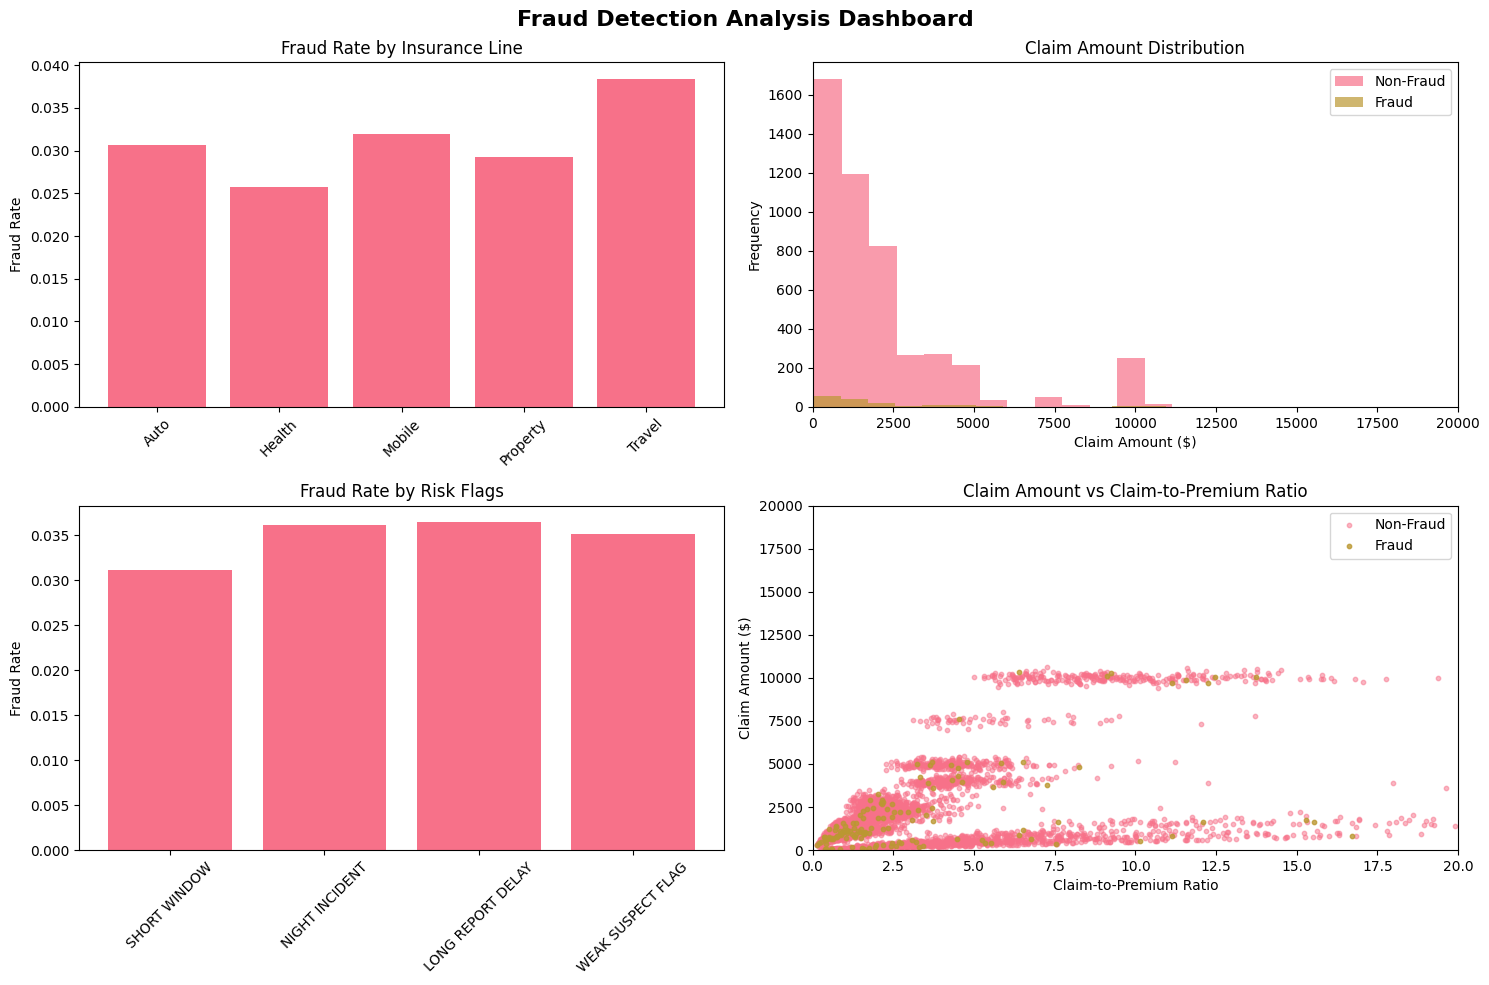

Visualizations created!


In [1]:
# Fraud Detection System
# A beginner-friendly Python implementation for insurance fraud detection

"""
Insurance Fraud Detection System

This script shows how to build a full machine learning process to find fraudulent insurance claims using details like claim amount, policy information, and customer behavior.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Machine learning imports
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score


class FraudDetector:
    """
    A complete fraud detection system for insurance claims.
    
    This class handles data loading, preprocessing, feature engineering,
    model training, and evaluation in a beginner-friendly way.
    """
    
    def __init__(self, data_path=None):
        """
        Initialize the fraud detection system.
        
        Args:
            data_path (str): Path to the dataset CSV file
        """
        self.data_path = 'D:\project\Fraud_detection\synthetic_fraud_risk_dataset.csv'
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model = None
        self.preprocessor = None
        
    def load_data(self, file_path=None):
        """
        Load the insurance claims dataset.
        
        Args:
            file_path (str): Path to CSV file (optional, uses self.data_path if not provided)
        """
        if file_path:
            self.data_path = file_path
            
        print(f"Loading data from: {self.data_path}")
        
        try:
            # Load the dataset
            self.df = pd.read_csv(self.data_path, parse_dates=['POLICY_EFFECTIVE_DATE', 'LOSS_DATE', 'REPORT_DATE'])
            print(f"Data loaded successfully! Shape: {self.df.shape}")
            
            # Display basic info
            print("\n Dataset Overview:")
            print(f"- Total claims: {len(self.df):,}")
            print(f"- Features: {self.df.shape[1]}")
            print(f"- Fraud cases: {self.df['FRAUD_LABEL'].sum():,}")
            print(f"- Fraud rate: {self.df['FRAUD_LABEL'].mean():.2%}")
            
        except FileNotFoundError:
            print(f"Error: Could not find file at {self.data_path}")
            print("Please check the file path and try again.")
        except Exception as e:
            print(f"Error loading data: {str(e)}")
    
    def explore_data(self):
        """
        Perform basic exploratory data analysis and show key insights.
        """
        if self.df is None:
            print("No data loaded. Please run load_data() first.")
            return
            
        print("EXPLORATORY DATA ANALYSIS")
        print("=" * 50)
        
        # Basic statistics
        print("\nKey Statistics:")
        print(f"- Average claim amount: ${self.df['CLAIM_AMOUNT'].mean():,.2f}")
        print(f"- Average premium: ${self.df['PREMIUM_AMOUNT'].mean():,.2f}")
        print(f"- Average claim-to-premium ratio: {self.df['CLAIM_TO_PREMIUM_RATIO'].mean():.2f}")
        
        # Missing values check
        missing = self.df.isnull().sum()
        if missing.any():
            print(f"\nMissing values found in {missing[missing > 0].shape[0]} columns")
        else:
            print("\nNo missing values found")
            
        # Target variable distribution
        fraud_counts = self.df['FRAUD_LABEL'].value_counts()
        print(f"\nTarget Variable Distribution:")
        print(f"- Non-fraudulent claims: {fraud_counts[0]:,} ({fraud_counts[0]/len(self.df):.1%})")
        print(f"- Fraudulent claims: {fraud_counts[1]:,} ({fraud_counts[1]/len(self.df):.1%})")
        
        # Show some high-risk patterns
        print(f"\nHigh-Risk Patterns:")
        high_ratio = self.df[self.df['CLAIM_TO_PREMIUM_RATIO'] > 10]
        print(f"- Claims with ratio > 10: {len(high_ratio)} ({high_ratio['FRAUD_LABEL'].mean():.1%} fraud rate)")
        
        night_incidents = self.df[self.df['FLAG_NIGHT_INCIDENT'] == 1]
        print(f"- Night incidents: {len(night_incidents)} ({night_incidents['FRAUD_LABEL'].mean():.1%} fraud rate)")
        
    def create_features(self):
        """
        Create and engineer features for the machine learning model.
        """
        if self.df is None:
            print("No data loaded. Please run load_data() first.")
            return
            
        print("FEATURE ENGINEERING")
        print("=" * 50)
        
        # Calculate time intervals (already done in the dataset, but let's verify)
        self.df['DAYS_POLICY_TO_LOSS'] = (self.df['LOSS_DATE'] - self.df['POLICY_EFFECTIVE_DATE']).dt.days
        self.df['DAYS_LOSS_TO_REPORT'] = (self.df['REPORT_DATE'] - self.df['LOSS_DATE']).dt.days
        
        # Create risk flags (already in dataset, but showing the logic)
        self.df['FLAG_SHORT_WINDOW'] = (self.df['DAYS_POLICY_TO_LOSS'] <= 30).astype(int)
        self.df['FLAG_LONG_REPORT_DELAY'] = (self.df['DAYS_LOSS_TO_REPORT'] >= 21).astype(int)
        self.df['FLAG_NIGHT_INCIDENT'] = self.df['INCIDENT_HOUR'].apply(lambda x: 1 if x <= 6 or x >= 22 else 0)
        
        print("Feature engineering completed!")
        print("\n Key Features Created:")
        print("- Time-based: Days from policy to loss, days from loss to report")
        print("- Risk flags: Short window, long delay, night incident, weak suspect")
        print("- Financial: Claim-to-premium ratio")
        
    def prepare_data(self):
        """
        Prepare data for machine learning by splitting and preprocessing.
        """
        if self.df is None:
            print("No data loaded. Please run load_data() first.")
            return
            
        print("DATA PREPARATION")
        print("=" * 50)
        
        # Define features to use
        numeric_features = [
            'PREMIUM_AMOUNT', 'CLAIM_AMOUNT', 'CLAIM_TO_PREMIUM_RATIO',
            'DAYS_POLICY_TO_LOSS', 'DAYS_LOSS_TO_REPORT'
        ]
        
        flag_features = [
            'FLAG_SHORT_WINDOW', 'FLAG_LONG_REPORT_DELAY', 
            'FLAG_NIGHT_INCIDENT', 'WEAK_SUSPECT_FLAG'
        ]
        
        categorical_features = [
            'INSURANCE_LINE', 'INCIDENT_SEVERITY', 'RISK_SEGMENTATION'
        ]
        
        # Combine all features
        all_features = numeric_features + flag_features + categorical_features
        
        # Create feature matrix and target
        X = self.df[all_features]
        y = self.df['FRAUD_LABEL']
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
        
        # Create preprocessing pipeline
        # For numeric features: standardize (mean=0, std=1)
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
        
        # For categorical features: one-hot encode
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ])
        
        # Combine preprocessing steps
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features + flag_features),
                ('cat', categorical_transformer, categorical_features)
            ],
            remainder='passthrough'
        )
        
        print("Data preparation completed!")
        print(f"- Training set: {len(self.X_train):,} samples")
        print(f"- Test set: {len(self.X_test):,} samples")
        print(f"- Features: {len(all_features)}")
        print(f"- Fraud rate in training: {self.y_train.mean():.2%}")
        
    def train_model(self, model_type='logistic'):
        """
        Train a machine learning model for fraud detection.
        
        Args:
            model_type (str): Type of model to train ('logistic' or 'random_forest')
        """
        if self.X_train is None:
            print("No prepared data found. Please run prepare_data() first.")
            return

        print(f"TRAINING {model_type.upper().replace('_', ' ')} MODEL")
        print("=" * 50)

        if model_type == 'logistic':
            from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
            import numpy as np

            # Base Logistic Regression
            classifier = LogisticRegression(
                solver="saga", 
                max_iter=5000, 
                random_state=42
            )

            # Create pipeline with preprocessing + classifier
            pipe = Pipeline(steps=[
                ('preprocessor', self.preprocessor),
                ('classifier', classifier)
            ])

            # Define hyperparameter search space
            param_distributions = {
                "classifier__C": np.logspace(-4, 4, 50),
                "classifier__penalty": ["l1", "l2", "elasticnet"],
                "classifier__l1_ratio": np.linspace(0, 1, 11),  # for elasticnet
                "classifier__class_weight": [None, "balanced"]
            }

            # Stratified CV
            cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            # Randomized search
            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=param_distributions,
                n_iter=40,
                scoring="average_precision",   # better for imbalance
                cv=cv_strategy,
                n_jobs=-1,
                verbose=2,
                random_state=42,
                refit=True
            )

            print("Running hyperparameter tuning for Logistic Regression...")
            search.fit(self.X_train, self.y_train)

            print("\nBest Parameters Found:", search.best_params_)
            print("Best CV PR-AUC Score:", search.best_score_)

            self.model = search.best_estimator_
            print("Tuned Logistic Regression model ready!")

        elif model_type == 'random_forest':
            classifier = RandomForestClassifier(
                n_estimators=100,
                class_weight='balanced',
                random_state=42,
                max_depth=10
            )
            print("Using Random Forest with 100 trees")

            self.model = Pipeline(steps=[
                ('preprocessor', self.preprocessor),
                ('classifier', classifier)
            ])

            print("Training Random Forest...")
            self.model.fit(self.X_train, self.y_train)
            print("Random Forest training completed!")

        else:
            print(f"Unknown model type: {model_type}")
            return

        
    def evaluate_model(self):
        """
        Evaluate the trained model and show performance metrics.
        """
        if self.model is None:
            print("No trained model found. Please run train_model() first.")
            return
            
        print("MODEL EVALUATION")
        print("=" * 50)
        
        # Make predictions
        y_pred = self.model.predict(self.X_test)
        y_proba = self.model.predict_proba(self.X_test)[:, 1]
        
        # Calculate metrics
        roc_auc = roc_auc_score(self.y_test, y_proba)
        pr_auc = average_precision_score(self.y_test, y_proba)
        
        print(f"Performance Metrics:")
        print(f"- ROC AUC Score: {roc_auc:.4f}")
        print(f"- PR AUC Score: {pr_auc:.4f}")
        
        # Show confusion matrix
        print(f"\nConfusion Matrix:")
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)
        
        # Detailed classification report
        print(f"\nDetailed Performance Report:")
        print(classification_report(self.y_test, y_pred, digits=4))
        
        # Interpretation help
        print(f"\nInterpretation:")
        tn, fp, fn, tp = cm.ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        print(f"- True Positives (Fraud correctly identified): {tp}")
        print(f"- False Positives (Non-fraud flagged as fraud): {fp}")
        print(f"- False Negatives (Fraud missed): {fn}")
        print(f"- True Negatives (Non-fraud correctly identified): {tn}")
        print(f"- Model catches {recall:.1%} of all fraud cases")
        print(f"- When model flags fraud, it's correct {precision:.1%} of the time")
        
    def predict_new_claims(self, new_data):
        """
        Predict fraud probability for new insurance claims.
        
        Args:
            new_data (pd.DataFrame): New claims data with same features
            
        Returns:
            np.array: Fraud probabilities for each claim
        """
        if self.model is None:
            print("No trained model found. Please run train_model() first.")
            return None
            
        # Make predictions
        probabilities = self.model.predict_proba(new_data)[:, 1]
        predictions = self.model.predict(new_data)
        
        # Create results dataframe
        results = pd.DataFrame({
            'Fraud_Probability': probabilities,
            'Fraud_Prediction': predictions,
            'Risk_Level': pd.cut(probabilities, bins=[0, 0.3, 0.7, 1.0], 
                               labels=['Low', 'Medium', 'High'])
        })
        
        return results
        
    def create_visualizations(self):
        """
        Create helpful visualizations for understanding the data and model.
        """
        if self.df is None:
            print("No data loaded. Please run load_data() first.")
            return
            
        print("CREATING VISUALIZATIONS")
        print("=" * 50)
        
        # Set style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # 1. Fraud distribution
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Fraud Detection Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # Fraud rate by insurance line
        fraud_by_line = self.df.groupby('INSURANCE_LINE')['FRAUD_LABEL'].agg(['count', 'sum', 'mean']).reset_index()
        fraud_by_line['fraud_rate'] = fraud_by_line['mean']
        
        axes[0,0].bar(fraud_by_line['INSURANCE_LINE'], fraud_by_line['fraud_rate'])
        axes[0,0].set_title('Fraud Rate by Insurance Line')
        axes[0,0].set_ylabel('Fraud Rate')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # Claim amount distribution
        axes[0,1].hist(self.df[self.df['FRAUD_LABEL']==0]['CLAIM_AMOUNT'], alpha=0.7, label='Non-Fraud', bins=30)
        axes[0,1].hist(self.df[self.df['FRAUD_LABEL']==1]['CLAIM_AMOUNT'], alpha=0.7, label='Fraud', bins=30)
        axes[0,1].set_title('Claim Amount Distribution')
        axes[0,1].set_xlabel('Claim Amount ($)')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].legend()
        axes[0,1].set_xlim(0, 20000)  # Focus on main range
        
        # Risk flags comparison
        risk_cols = ['FLAG_SHORT_WINDOW', 'FLAG_NIGHT_INCIDENT', 'FLAG_LONG_REPORT_DELAY', 'WEAK_SUSPECT_FLAG']
        risk_fraud_rates = []
        
        for col in risk_cols:
            rate = self.df[self.df[col]==1]['FRAUD_LABEL'].mean()
            risk_fraud_rates.append(rate)
            
        axes[1,0].bar(range(len(risk_cols)), risk_fraud_rates)
        axes[1,0].set_title('Fraud Rate by Risk Flags')
        axes[1,0].set_ylabel('Fraud Rate')
        axes[1,0].set_xticks(range(len(risk_cols)))
        axes[1,0].set_xticklabels([col.replace('FLAG_', '').replace('_', ' ') for col in risk_cols], rotation=45)
        
        # Claim-to-premium ratio
        axes[1,1].scatter(self.df[self.df['FRAUD_LABEL']==0]['CLAIM_TO_PREMIUM_RATIO'], 
                         self.df[self.df['FRAUD_LABEL']==0]['CLAIM_AMOUNT'], 
                         alpha=0.5, label='Non-Fraud', s=10)
        axes[1,1].scatter(self.df[self.df['FRAUD_LABEL']==1]['CLAIM_TO_PREMIUM_RATIO'], 
                         self.df[self.df['FRAUD_LABEL']==1]['CLAIM_AMOUNT'], 
                         alpha=0.8, label='Fraud', s=10)
        axes[1,1].set_title('Claim Amount vs Claim-to-Premium Ratio')
        axes[1,1].set_xlabel('Claim-to-Premium Ratio')
        axes[1,1].set_ylabel('Claim Amount ($)')
        axes[1,1].legend()
        axes[1,1].set_xlim(0, 20)  # Focus on main range
        axes[1,1].set_ylim(0, 20000)
        
        plt.tight_layout()
        plt.show()
        
        print("Visualizations created!")


def main():
    """
    Main function demonstrating how to use the FraudDetector class.
    """
    print("INSURANCE FRAUD DETECTION SYSTEM")
    print("=" * 60)
    print("This system helps identify potentially fraudulent insurance claims")
    print("using machine learning techniques.\n")
    
    # Initialize the fraud detector
    detector = FraudDetector()
    
    # Load and explore data
    detector.load_data('synthetic_fraud_risk_dataset.csv')  # Update path as needed
    detector.explore_data()
    
    # Feature engineering and data preparation
    detector.create_features()
    detector.prepare_data()
    
    # Train models
    print("\n" + "="*60)
    detector.train_model('logistic')
    detector.evaluate_model()
    
    print("\n" + "="*60)
    detector.train_model('random_forest')
    detector.evaluate_model()
    
    # Create visualizations
    detector.create_visualizations()
    


if __name__ == "__main__":
    main()

In [3]:
import joblib

# Initialize and train the detector if not already done
detector = FraudDetector()
detector.load_data('synthetic_fraud_risk_dataset.csv')
detector.create_features()
detector.prepare_data()
detector.train_model('logistic')

# Save the trained model
joblib.dump(detector.model, "model.pkl")

Loading data from: synthetic_fraud_risk_dataset.csv
Data loaded successfully! Shape: (5000, 30)

 Dataset Overview:
- Total claims: 5,000
- Features: 30
- Fraud cases: 153
- Fraud rate: 3.06%
FEATURE ENGINEERING
Feature engineering completed!

 Key Features Created:
- Time-based: Days from policy to loss, days from loss to report
- Risk flags: Short window, long delay, night incident, weak suspect
- Financial: Claim-to-premium ratio
DATA PREPARATION
Data preparation completed!
- Training set: 4,000 samples
- Test set: 1,000 samples
- Features: 12
- Fraud rate in training: 3.05%
TRAINING LOGISTIC MODEL
Running hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters Found: {'classifier__penalty': 'l2', 'classifier__l1_ratio': np.float64(0.1), 'classifier__class_weight': 'balanced', 'classifier__C': np.float64(0.0029470517025518097)}
Best CV PR-AUC Score: 0.04848948700561145
Tuned Logistic Regression model ready!


['model.pkl']